In [1]:
import sys
sys.path.append('/home/suo/dev/chexpert-fusion/fusion_experiments')

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/home/suo/.cache/bazel/_bazel_suo/179b959b51786362378d993292d897d3/execroot/__main__/bazel-out/release_links/lib/python_env/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [68]:
from config.chexpert import CHEXPERT_CLASSES
from config.chexpert import PAPER_TRAINING_CLASSES
from data.datasets.paired_chexpert import PairedCheXpertDataset
from data.datasets.paired_chexpert import PairedOnlyCheXpertDataset
from data.datasets.paired_chexpert import PairedOnlyCustomSplit
from data.datasets.paired_mimic import PairedOnlyMIMICDataset

MODE = 'train'
CLASS_NAMES = PAPER_TRAINING_CLASSES
DATASET_PATH = '/home/suo/data/CheXpert-v1.0'
MIMIC_DATASET_PATH = '/home/suo/data/MIMIC-CXR'
SET_UNOBSERVED_TO_NEGATIVE = True

dataset1 = PairedCheXpertDataset(DATASET_PATH, MODE, CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)
dataset2 = PairedOnlyCheXpertDataset(DATASET_PATH, MODE, CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)

In [63]:
mimic_dataset = PairedOnlyMIMICDataset(MIMIC_DATASET_PATH, 'valid', CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)

In [52]:
train_dataset = PairedOnlyCustomSplit(DATASET_PATH, 'train', CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)
valid_dataset = PairedOnlyCustomSplit(DATASET_PATH, 'test', CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)

In [69]:
dataset1 = mimic_dataset

In [70]:
train_patients = set([])
train_patient_studies = {}
for study in train_dataset.studies:
    train_patients.add(study['patient'])
    train_patient_studies[study['patient']] = study
    
valid_patients = set([])
valid_patient_studies = {}
for study in valid_dataset.studies:
    valid_patients.add(study['patient'])
    valid_patient_studies[study['patient']] = study

In [71]:
debug = False

if debug:
    print(list(train_patients.intersection(valid_patients))[3])
    print(train_patient_studies['patient18283'])
    print(valid_patient_studies['patient18283'])

In [72]:
LABEL_DISTRIBUTION1 = [np.zeros(len(CLASS_NAMES)), np.zeros(len(CLASS_NAMES)), np.zeros(len(CLASS_NAMES))]

for study in dataset1.studies:
    LABEL_DISTRIBUTION1[0] += (study['labels'] == 0) * study['mask']
    LABEL_DISTRIBUTION1[1] += (study['labels'] == 1) * study['mask']
    LABEL_DISTRIBUTION1[2] += np.ones_like(study['labels'])
    
print('Negatives: {}'.format(LABEL_DISTRIBUTION1[0]))
print('Positives: {}'.format(LABEL_DISTRIBUTION1[1]))
print('Total: {}'.format(LABEL_DISTRIBUTION1[2]))

Negatives: [ 760.  821.  846.  752.  746.]
Positives: [ 109.   35.   22.  104.  113.]
Total: [ 880.  880.  880.  880.  880.]


In [73]:
LABEL_DISTRIBUTION2 = [np.zeros(len(CLASS_NAMES)), np.zeros(len(CLASS_NAMES)), np.zeros(len(CLASS_NAMES))]

for study in dataset2.studies:
    LABEL_DISTRIBUTION2[0] += (study['labels'] == 0) * study['mask']
    LABEL_DISTRIBUTION2[1] += (study['labels'] == 1) * study['mask']
    LABEL_DISTRIBUTION2[2] += np.ones_like(study['labels'])
    
print('Negatives: {}'.format(LABEL_DISTRIBUTION2[0]))
print('Positives: {}'.format(LABEL_DISTRIBUTION2[1]))
print('Total: {}'.format(LABEL_DISTRIBUTION2[2]))

Negatives: [ 26609.  27871.  26437.  24136.  20409.]
Positives: [ 3472.  2437.  1733.  3539.  9002.]
Total: [ 31413.  31413.  31413.  31413.  31413.]


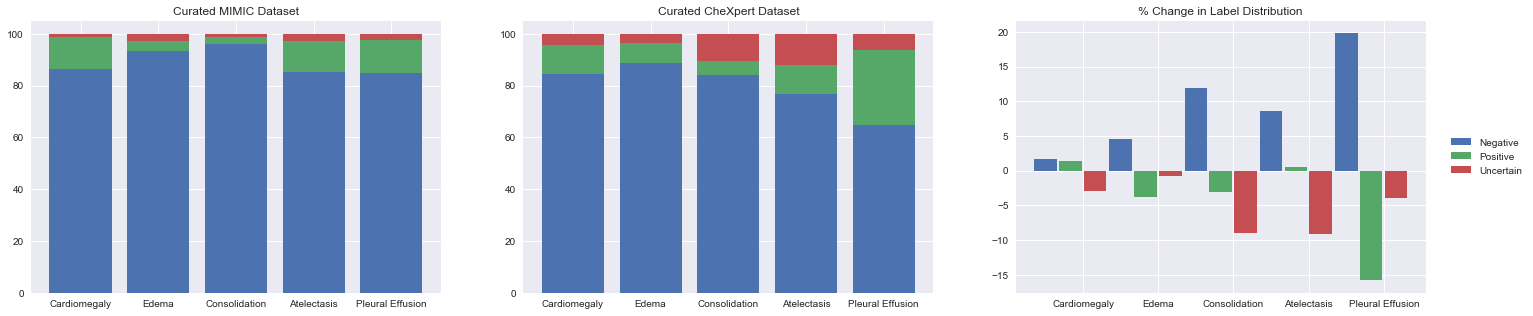

In [76]:
NEGATIVE_DISTRIBUTION1 = LABEL_DISTRIBUTION1[0] / LABEL_DISTRIBUTION1[2] * 100
POSITIVE_DISTRIBUTION1 = LABEL_DISTRIBUTION1[1] / LABEL_DISTRIBUTION1[2] * 100
UNCERTAIN_DISTRIBUTION1 = (LABEL_DISTRIBUTION1[2] - LABEL_DISTRIBUTION1[1] - LABEL_DISTRIBUTION1[0]) / LABEL_DISTRIBUTION1[2] * 100

NEGATIVE_DISTRIBUTION2 = LABEL_DISTRIBUTION2[0] / LABEL_DISTRIBUTION2[2] * 100
POSITIVE_DISTRIBUTION2 = LABEL_DISTRIBUTION2[1] / LABEL_DISTRIBUTION2[2] * 100
UNCERTAIN_DISTRIBUTION2 = (LABEL_DISTRIBUTION2[2] - LABEL_DISTRIBUTION2[1] - LABEL_DISTRIBUTION2[0]) / LABEL_DISTRIBUTION2[2] * 100

BAR_WIDTH = 0.8
FIGURE, AXES = plt.subplots(ncols=3)
FIGURE.set_figwidth(25)
FIGURE.set_figheight(5)

b1 = AXES[0].bar(range(len(NEGATIVE_DISTRIBUTION1)), NEGATIVE_DISTRIBUTION1, width=BAR_WIDTH, label='Negative')
b2 = AXES[0].bar(range(len(NEGATIVE_DISTRIBUTION1)), POSITIVE_DISTRIBUTION1, width=BAR_WIDTH, bottom=NEGATIVE_DISTRIBUTION1, label='Positive')
b3 = AXES[0].bar(range(len(NEGATIVE_DISTRIBUTION1)), UNCERTAIN_DISTRIBUTION1, width=BAR_WIDTH, bottom=(POSITIVE_DISTRIBUTION1 + NEGATIVE_DISTRIBUTION1),label='Uncertain')

b4 = AXES[1].bar(range(len(NEGATIVE_DISTRIBUTION2)), NEGATIVE_DISTRIBUTION2, width=BAR_WIDTH, label='Negative')
b5 = AXES[1].bar(range(len(NEGATIVE_DISTRIBUTION2)), POSITIVE_DISTRIBUTION2, width=BAR_WIDTH, bottom=NEGATIVE_DISTRIBUTION2, label='Positive')
b6 = AXES[1].bar(range(len(NEGATIVE_DISTRIBUTION2)), UNCERTAIN_DISTRIBUTION2, width=BAR_WIDTH, bottom=(POSITIVE_DISTRIBUTION2 + NEGATIVE_DISTRIBUTION2),label='Uncertain')

b7 = AXES[2].bar(range(len(NEGATIVE_DISTRIBUTION2)), NEGATIVE_DISTRIBUTION1 - NEGATIVE_DISTRIBUTION2, width=0.3, label='Negative')
b8 = AXES[2].bar([x + 0.33 for x in range(len(NEGATIVE_DISTRIBUTION2))], POSITIVE_DISTRIBUTION1 - POSITIVE_DISTRIBUTION2, width=0.3, label='Positive')
b9 = AXES[2].bar([x + 0.66 for x in range(len(NEGATIVE_DISTRIBUTION2))], UNCERTAIN_DISTRIBUTION1 - UNCERTAIN_DISTRIBUTION2, width=0.3, label='Uncertain')


# AXES[1].bar(range(len(NEGATIVE_DISTRIBUTION2)), POSITIVE_DISTRIBUTION2, width=BAR_WIDTH, bottom=NEGATIVE_DISTRIBUTION2, label='Positive')
# AXES[1].bar(range(len(NEGATIVE_DISTRIBUTION2)), UNCERTAIN_DISTRIBUTION2, width=BAR_WIDTH, bottom=(POSITIVE_DISTRIBUTION2 + NEGATIVE_DISTRIBUTION2),label='Uncertain')

# AXES[0].xlabel('% of Total Labels' )
AXES[0].set_xticks([x for x in range(len(NEGATIVE_DISTRIBUTION1))])
AXES[0].set_xticklabels(CLASS_NAMES, rotation=0)
# AXES[1].get_yaxis().set_visible(False)
AXES[1].set_xticks([x for x in range(len(NEGATIVE_DISTRIBUTION1))])
AXES[1].set_xticklabels(CLASS_NAMES, rotation=0)
# AXES[2].get_yaxis().set_visible(False)
AXES[2].set_xticks([x + 0.5 for x in range(len(NEGATIVE_DISTRIBUTION1))])
AXES[2].set_xticklabels(CLASS_NAMES, rotation=0)

AXES[0].set_title('Curated MIMIC Dataset')
AXES[1].set_title('Curated CheXpert Dataset')
AXES[2].set_title('% Change in Label Distribution')

AXES[2].legend([b7, b8, b9], ['Negative', 'Positive', 'Uncertain'], bbox_to_anchor=(1.04, 0.5), loc='center left')
# plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
# FIGURE.legend(loc='lower left', mode='expand', ncol=3)

plt.show()

CheXpert has significantly more positive labels than MIMIC

MIMIC is better dataset to train on

Baseline just predicts no more often, so its performance generalizes better? 